In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf

In [4]:
from wgomoku import (
    GomokuTools as gt, SampleDataHelper, GomokuBoard, Heuristics,
    PolicyModel, ValueModel, TerminalDetector, display_sample, 
    analyse_and_recommend, SelfPlay)

In [5]:
N=19

---
# Load the Policy and Value Models

In [6]:
latest_policy_model = tf.train.latest_checkpoint("./models/PolicyNet_1.0/")
print(latest_policy_model)
policy_model = PolicyModel(board_size=19, n_blocks=10, 
                    n_layers=3, n_filters=32, 
                    activation='relu')
policy_model.load_weights(latest_policy_model)

./models/PolicyNet_1.0/cp-0006.ckpt


In [7]:
latest_value_model = tf.train.latest_checkpoint("./models/ValueNet_3.0/")
print(latest_value_model)
value_model = ValueModel(19, 10, 3, 32, 'relu')
value_model.load_weights(latest_value_model)

./models/ValueNet_3.0/cp-0001.ckpt


In [8]:
sdh = SampleDataHelper(N, representation='NxNx1B', cut_off=12)

---
# Self-Play

In [9]:
sp = SelfPlay(policy=policy_model, board_size=19)

You can create a single episode. The ```traj``` return value is the trajectory, also referred to as *stones* or *moves*. They come in board coordinates

In [10]:
game, traj, terminated = sp.create_episode(limit=50, n_choices=10, greedy_bias=300)

In [11]:
episodes = sp.create_episodes(3)
print(episodes[0])

[array([10, 10]), array([ 8, 12]), array([ 8, 10]), array([ 7, 11]), array([ 9, 10]), array([ 9, 13]), array([10, 14]), array([ 7, 10]), array([7, 9]), array([ 7, 13]), array([10, 13]), array([ 5, 15]), array([ 6, 14]), array([10, 11]), array([ 9, 14]), array([ 7, 16]), array([ 7, 15]), array([ 5, 13]), array([10, 16]), array([ 6, 10]), array([ 7, 14]), array([ 4, 14]), array([5, 9]), array([ 6, 13]), array([ 8, 14])]


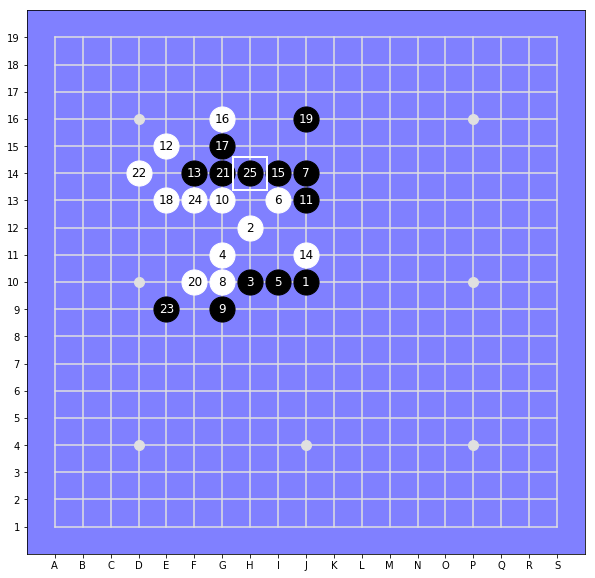

In [12]:
board = GomokuBoard(N=19, heuristics=Heuristics(kappa=3.0), stones=episodes[0], 
                    disp_width=10)
board.display()

# Value Function Fitting
Now we create a dataset for fitting the value function. The labels are:

$$
y_{i,t} = r(s_{i,t}, a_{i,t}) + \hat V_{\phi}^{\pi}(s_{i,t+2})
$$

Note the index $t+2$ in the value function. We're training by fitting to the next sample of the same player.

## Generating Samples 
```tf.keras``` can create ```tf.data``` datasets from generators. We use class ```A2C_SampleGeneratorFactory``` to create a fresh sample using the current policy.

In [13]:
from wgomoku import A2C_SampleGeneratorFactory

### Understandig the *shift*

The following depiction should help understand method ```_generator``` of class ```A2C_SampleGeneratorFactory```


S0, S1, S2, S3, S4, S5, S6, S7, S8   # sample positions

V2, V3, V4, V5, V6, V7, V8, +1, -1   # shifted to the left, padded with -1, 1 and multiplied by gamma
                                     

V0, V1, V2, V3, V4, V5, V6, V7, V8

You can easily convince yourself that the target definitions for the value update and the policy update can be taken from this setup.

In [14]:
gamma = 0.9
n_episodes = 16
episodes = sp.create_episodes(n_episodes)

Now we train the value network for five epochs

In [16]:
factory = A2C_SampleGeneratorFactory(19, value_model, gamma=0.9, cut_off=None)
generator = factory.create_generator(episodes, kind='values')

inputs = tf.data.Dataset.from_generator(
    generator, output_types=(tf.int32, tf.float32))

inputs = inputs.shuffle(100).repeat(5).batch(512)

W0803 15:14:42.270310 140475651430144 deprecation.py:323] From /home/wgiersche/workspace/DeepGomoku/tf2/lib/python3.5/site-packages/tensorflow/python/data/ops/dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Below: A batch of samples from the self-play 

In [17]:
s, v = next(iter(inputs))
s.shape, v.shape

(TensorShape([512, 21, 21, 2]), TensorShape([512]))

In [18]:
latest_value_model = tf.train.latest_checkpoint("./models/ValueNet_3.0/")
print(latest_value_model)
value_model = ValueModel(19, 10, 3, 32, 'relu')
value_model.load_weights(latest_value_model)

./models/ValueNet_3.0/cp-0001.ckpt


In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3)
value_model.compile(optimizer=optimizer, loss='mean_squared_error')
value_model.fit(inputs)

35/35 [==============================] - 30s 860ms/step - loss: 0.1223


After a while you may observe more and more of the alternating pattern sneaking in from the end of the episodes.

In [20]:
samples = sdh.traj_to_samples(episodes[2], -1, gamma)
print(np.shape(samples[0]))
values = value_model.call(samples[0])
values[-10:]

(31, 21, 21, 2)


<tf.Tensor: id=405478, shape=(10, 1), dtype=float32, numpy=
array([[ 0.16193187],
       [-0.3214573 ],
       [ 0.1968301 ],
       [-0.4022821 ],
       [ 0.18294372],
       [-0.5627495 ],
       [ 0.23414357],
       [-0.5757381 ],
       [ 0.2656413 ],
       [-0.7591528 ]], dtype=float32)>

---
# Computing advantages
$$
\hat{A}^\pi(s_i, a_i) = r(s_i, a_i) + \gamma\hat{V}_\phi^\pi(s_{i+2}) - \hat{V}_\phi^\pi(s_i)
$$

In [21]:
np.shape(episodes[2]), episodes[2][1], episodes[2][4]

((31, 2), array([ 8, 12]), array([ 9, 13]))

In [22]:
samples, values = sdh.traj_to_samples(episodes[2], -1, gamma)
print(np.shape(samples))

(31, 21, 21, 2)


In [23]:
display_sample(samples[3]), display_sample(samples[4])

[[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  1  0 -1  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0

(None, None)

---
Remember: A sample is equal to the previous in the episode, multiplied by -1, plus a new stone, also set to -1. That's how we address the *current player* problem.
That means: If we numerically add two adjacent samples, all but the new stone cancel out.
We don't care about the borders as we take only the first channel after the usual ```np.rollaxis``` trick. Then we drop the first and the last row, flip diagonally (=transpose the matrix), drop again first and last row and flip the matrix back.
What we end up with is a 19x19 mask that *looks at* only the probability of the action that has actually been taken. And only that one is supposed to receive the gradients that represent penalty or reward. 

In [24]:
t = 3
mask = np.rollaxis(np.abs(samples[t+1]+samples[t]), 2, 0)[0][1:-1].T[1:-1].T
mask

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [26]:
pos = np.divmod(np.argmax(mask), 19)
gt.m2b(pos, 19)

array([13, 11])

In [27]:
# undo the padding offset and translate to board coordinates
m = episodes[2][4] - (1,1)
gt.m2b(m, 19)

array([13, 11])